In [1]:
import os
from pathlib import Path
from PIL import Image

import numpy as np

import torch
from torch.utils.data import Dataset,DataLoader
from torchvision.transforms import functional as TF

In [2]:
DATA_ROOT='./data/CUB_200_2011'
BATCH_SIZE=8
NUM_WORERS=4
EPOCHS=5
LR=0.005
MOMENTUM=0.9
WEIGHT_DECAY=0.0001

IMG_SIZE=512
N_CLASSES=2
IGNORE_INDEX=255

In [3]:
def make_transform(train):
    def _tfm(img,mask):
        img= TF.resize(img,(IMG_SIZE,IMG_SIZE))
        mask= TF.resize(mask,(IMG_SIZE,IMG_SIZE),interpolation=TF.InterpolationMode.NEAREST)
        if train and torch.rand(1)<0.5:
            img = TF.hflip(img)
            mask = TF.hflip(mask)
        img = TF.to_tensor(img)
        img = TF.normalize(img, [0.485,0.456,0.406], [0.229,0.224,0.225])
        mask_ck = np.array(mask)
        if mask_ck.dim==3:
            mask_ck=(mask_ck>0).any(axis=2).astype(np.uint8)
        mask=torch.as_tensor(mask_ck,dtype=torch.long)
        return img,mask
    return _tfm
class CUBBinarySg(Dataset):
    def __init__(self,root,img_id,id2path,tf=None):
        self.root=Path(root)
        self.ids=img_id
        self.id2path=id2path
        self.tf=tf
        self.img_dir=self.root/'images'
        self.seg_dir=self.root/'segmentations'
    def __len__(self):
        return len(self.ids)
        
    def __getitem__(self,idx):
        img_idx=self.ids[idx]
        img_path=self.id2path[img_idx]
        img_path_call=self.img_dir/img_path
        img=Image.open(img_path_call).convert('RGB')

        sg_path_call=(self.seg_dir/img_path).with_suffix('.png')
        mask=Image.open(sg_path_call)
        mask_np=np.array(mask)
        if mask_np.ndim==3:
            mask_np=(mask_np>0).any(axis=2).astype(np.uint8)
        else:
            mask_np=(mask_np>0).astype(np.uint8)
        mask=Image.fromarray(mask_np,mode='L')

        if self.tf:
            img,mask =self.tf(img,mask)
        return img,mask 

def read_id_to_path(root):
    id2path={}
    with open(os.path.join(root,'images.txt'),'r') as f:
        for i in f:
            idx,p=i.strip().split(' ')
            id2path[int(idx)]=p
    return id2path
def read_tr_test_split(root):
    split={}
    with open(os.path.join(root,'train_test_split.txt'),'r') as f:
        for i in f:
            idx,is_train=i.strip().split(' ')
            split[int(idx)]=int(is_train)
    return split

def get_loaders():
    root=DATA_ROOT
    ck_l=[
        os.path.join(root,'images.txt'),
        os.path.join(root,'train_test_split.txt'),
        os.path.join(root,'images')
    ]
    for i in ck_l:
        if not (os.path.exists(i) and (os.path.isdir(i) or os.path.isfile(i))):
            raise FileNotFoundError(f"{i}파일 없습니다.")

    id2path=read_id_to_path(root)
    split=read_tr_test_split(root)

    tr_ids=[i for i, t in split.items() if t==1]
    val_ids=[i for i, t in split.items() if t==0]

    tr_ds=CUBBinarySg(root,tr_ids,id2path,tf=make_transform(True))
    val_ds=CUBBinarySg(root,val_ids,id2path,tf=make_transform(False))
    tr_ds_loader=DataLoader(tr_ds,batch_size=BATCH_SIZE,shuffle=True,num_workers=NUM_WORERS,pin_memory=True)
    val_ds_loader=DataLoader(val_ds,batch_size=BATCH_SIZE,shuffle=False,num_workers=NUM_WORERS,pin_memory=True)
    return tr_ds,val_ds,tr_ds_loader,val_ds_loader
tr_ds,val_ds,tr_ds_loader,val_ds_loader=get_loaders()    

In [4]:
import matplotlib.pyplot as plt
BG_COLOR=np.array([50,50,50],dtype=np.uint8)
BIRD_COLOR=np.array([200,50,50],dtype=np.uint8)
IGNORE_COLOR=np.array([100,100,100],dtype=np.uint8)

def _denorm(img):
    mean=torch.tensor([0.485, 0.456, 0.406],device=img.device)[:,None,None]
    std=torch.tensor([0.229, 0.224, 0.225],device=img.device)[:,None,None]
    img = (img*std+mean).clamp(0,1)
    return img.detach().cpu().numpy().transpose(1,2,0)
    
def _colorize_binary(mask_np,ignore_idx=255):
    out=np.zeros((*mask_np.shape,3),dtype=np.uint8)
    out[mask_np == 0]=BG_COLOR
    out[mask_np == 1]=BIRD_COLOR
    out[mask_np == ignore_idx]=IGNORE_COLOR
    return out

def overlay_mask(img_np,mask_rgb,alpha=0.5):
    base=(img_np*255).astype(np.uint8)
    over=(alpha*mask_rgb + (1-alpha)*base).astype(np.uint8)
    return over

def show_img_mask(ds,indices=None,n=6,alpha=0.5,ignore_idx=255):
    if indices is None:
        import random 
        n=min(n,len(ds))
        indices=random.sample(range(len(ds)),k=n)
    else:
        n=len(indices)
    r,c=n,3
    plt.figure(figsize=(c*4,r*3.5))

    for i, idx in enumerate(indices):
        sample=ds[idx]
        if len(sample)==3:
            img,mask,id_=sample
        else:
            img,mask=sample   
        img_np = _denorm(img)
        mask_np = np.array(mask)
        mask_rgb=_colorize_binary(mask_np,ignore_idx)
        over=overlay_mask(img_np,mask_rgb,alpha)

        base=i *3
        plt.subplot(r,c,base+1)
        plt.imshow(img_np)
        plt.title('img')
        plt.axis('off')
        
        plt.subplot(r,c,base+2)
        plt.imshow(mask_rgb)
        plt.title('mask')
        plt.axis('off')
        
        plt.subplot(r,c,base+3)
        plt.imshow(over)
        plt.title('overlay')
        plt.axis('off')

    plt.tight_layout()
    plt.show()    

In [5]:
show_img_mask(tr_ds,n=6)

AttributeError: 'numpy.ndarray' object has no attribute 'dim'

<Figure size 1200x2100 with 0 Axes>

In [ ]:
img=Image.open('./data/CUB_200_2011/segmentations/001.Black_footed_Albatross/Black_Footed_Albatross_0001_796111.png')

In [ ]:
np.unique(img.convert('L'))

In [32]:
np.unique(img)

array([  0,  51, 102, 153, 204, 255], dtype=uint8)

In [33]:
ck_img=Image.open('./data/VOCdevkit/VOC2012/SegmentationClass/2007_000032.png')
np.unique(ck_img)

array([  0,   1,  15, 255], dtype=uint8)

In [34]:
np.unique(ck_img.convert('L'))

array([  0,  38, 147, 220], dtype=uint8)

In [35]:
mask_img=img.convert('L')
mask=np.array(mask_img)

In [36]:
np.unique(mask)

array([  0,  51, 102, 153, 204, 255], dtype=uint8)

In [37]:
binary_mask=(mask>0).astype(np.uint8)

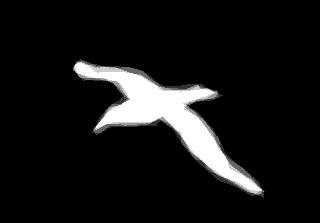

In [38]:
mask_img

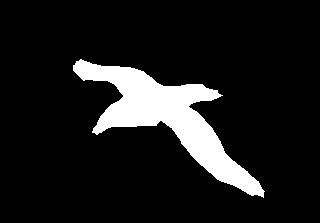

In [39]:
Image.fromarray(binary_mask*255)

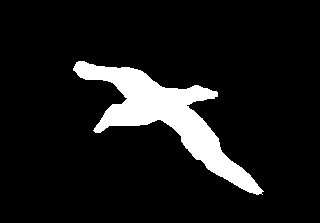

In [40]:
binary_mask=(mask>51).astype(np.uint8)
Image.fromarray(binary_mask*255)

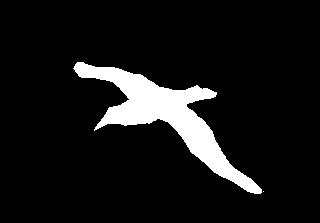

In [41]:
binary_mask=(mask>102).astype(np.uint8)
Image.fromarray(binary_mask*255)

In [42]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DoubleConv(nn.Module):
    def __init__(self,in_c,out_c):
        super().__init__()
        self.c1=nn.Conv2d(in_c,out_c,3,padding=0,bias=True)
        self.c2=nn.Conv2d(out_c,out_c,3,padding=0,bias=True)
        self.r=nn.ReLU(inplace=True)
    def forward(self,x):
        x=self.c1(x)
        x=self.c2(x)
        out=self.r(x)
        return out
    
class Down(nn.Module):
    def __init__(self,in_c,out_c):
        super().__init__()
        self.pool=nn.MaxPool2d(2)
        self.block=DoubleConv(in_c,out_c)
    def forward(self,x):
        x=self.pool(x)
        out=self.block(x)
        return out
        
class UP(nn.Module):
    def __init__(self,in_c,out_c):
        super().__init__()
        self.up=nn.ConvTranspose2d(in_c,in_c//2,2,stride=2)
        self.block=DoubleConv(in_c,out_c)
    def forward(self,x,skip):
        x=self.up(x)
        th,tw=x.shape[-2:]
        Hs,Ws=skip.shape[-2:]
        dh,dw=(Hs-th)//2,(Ws-tw)//2
        skip_c=skip[...,dh:dh+th,dw:dw+tw]
        x=torch.cat([skip_c,x],dim=1)
        out=self.block(x)
        return out

class UNet(nn.Module):
    def __init__(self,in_c=3,n_classes=1,base=64):
        super().__init__()
        self.inc=DoubleConv(in_c,base)
        self.down1=Down(base,base*2)
        self.down2=Down(base*2,base*4)
        self.down3=Down(base*4,base*8)
        self.down4=Down(base*8,base*16)
        self.up1=UP(base*16,base*8)
        self.up2=UP(base*8,base*4)
        self.up3=UP(base*4,base*2)
        self.up4=UP(base*2,base)
        self.outc=nn.Conv2d(base,n_classes,1)

    def forward(self,x):
        #인코딩층
        x1=self.inc(x)
        x2=self.down1(x1)
        x3=self.down2(x2)
        x4=self.down3(x3)
        x5=self.down4(x4)

        #디코더층
        x=self.up1(x5,x4)
        x=self.up2(x,x3)
        x=self.up3(x,x2)
        x=self.up4(x,x1)

        #출력층
        out=self.outc(x)
        return out

In [48]:
DEVICE=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DATA_ROOT='./data/CUB_200_2011'
BATCH_SIZE=8
NUM_WORERS=4
EPOCHS=5
LR=0.005
MOMENTUM=0.9
WEIGHT_DECAY=0.0001

IMG_SIZE=512
N_CLASSES=2
IGNORE_INDEX=255

OUT_DIR='runs'
BEST_PATH='./runs/best_m.pt'
os.makedirs(os.path.dirname(BEST_PATH),exist_ok=True)

import matplotlib.pyplot as plt
BG_COLOR=np.array([50,50,50],dtype=np.uint8)
BIRD_COLOR=np.array([200,50,50],dtype=np.uint8)
IGNORE_COLOR=np.array([100,100,100],dtype=np.uint8)

def _denorm(img):
    mean=torch.tensor([0.485, 0.456, 0.406],device=img.device)[:,None,None]
    std=torch.tensor([0.229, 0.224, 0.225],device=img.device)[:,None,None]
    img = (img*std+mean).clamp(0,1)
    return img.detach().cpu().numpy().transpose(1,2,0)
    
def _colorize_binary(mask_np,ignore_idx=255):
    out=np.zeros((*mask_np.shape,3),dtype=np.uint8)
    out[mask_np == 0]=BG_COLOR
    out[mask_np == 1]=BIRD_COLOR
    out[mask_np == ignore_idx]=IGNORE_COLOR
    return out

def overlay_mask(img_np,mask_rgb,alpha=0.5):
    base=(img_np*255).astype(np.uint8)
    over=(alpha*mask_rgb + (1-alpha)*base).astype(np.uint8)
    return over

def show_samples(loader,batches,alpha,ignore_idx):
    pass


In [ ]:
def center_crop(t,size_hw):
    H,W=t.shape[-2:]
    th,tw=size_hw
    dh,dw=(H-th)//2,(W-tw)//2
    if t.dim()==4:
        return t[...,dh:dh+th,dw:dw+tw]
    else:
        return t[:,dh:dh+th,dw:dw+tw]

In [ ]:
def fast_hist(pred,label,n_class=21,ignore_idx=255):
    mask=label!=ignore_idx
    pred=pred[mask]
    label=label[mask]
    hist=np.bincount(n_class*label.astype(int)+pred
    k=(0<=label) & (label<n_class)
    return np.bincount(n_class*label[k].astype(int)+pred[k].astype(int), minlength=n_class**2).reshape(n_class,n_class).astype(np.float64) 
def miou_from_hist(hist):
    iu = np.diag(hist)/(hist.sum(1)+hist.sum(0)-np.diag(hist)+1e-10)
    return float(np.nanmean(iu)),iu
@torch.no_gard()
def evaluate(model,loader,device,epoch):
    model.eval()
    it=iter(loader)
    for _ in range(batches):
        try:
            batch=next(it)
        except:
            break
        if len(batch)==3:
            

In [4]:
import os
import gdown
import tarfile

file_id = "1oJHd21eDCS1i1XE3pT88bFufddLslQg2"
url = f"https://drive.google.com/uc?id={file_id}"
output = "CUB_200_2011.tgz"
extract_path = "data/CUB_200_2011"

if not os.path.exists(output):
    print(f"Downloading {output} ...")
    gdown.download(url, output, quiet=False)
else:
    print(f"{output} 다운 되어있어서 스킵")

if os.path.isdir(extract_path) and len(os.listdir(extract_path)) > 0:
    print(f"{extract_path} 이미 압축 풀려있어서 스킵")
else:
    os.makedirs("data", exist_ok=True)
    with tarfile.open(output, "r:gz") as tar:
        tar.extractall("data")
    print("압축 해제 완료:", os.path.abspath(extract_path))

file_id = "1e_tA5XdK2OKFvqkPjk6xLuMxoyTOyjYD"
url = f"https://drive.google.com/uc?id={file_id}"
output = "segmentations.tgz"
extract_path = "data/CUB_200_2011/segmentations"

if not os.path.exists(output):
    print(f"Downloading {output} ...")
    gdown.download(url, output, quiet=False)
else:
    print(f"{output} 다운 되어있어서 스킵")

if os.path.isdir(extract_path) and len(os.listdir(extract_path)) > 0:
    print(f"{extract_path} 이미 압축 풀려있어서 스킵")
else:-
    os.makedirs("data/CUB_200_2011", exist_ok=True)
    with tarfile.open(output, "r:gz") as tar:
        tar.extractall("data/CUB_200_2011")
    print("압축 해제 완료:", os.path.abspath(extract_path))

Downloading...
From (original): https://drive.google.com/uc?id=1oJHd21eDCS1i1XE3pT88bFufddLslQg2
From (redirected): https://drive.google.com/uc?id=1oJHd21eDCS1i1XE3pT88bFufddLslQg2&confirm=t&uuid=359898ab-a730-432e-9c49-3b82e308dacf
To: /workspace/DL/CUB_200_2011.tgz
100%|██████████| 1.15G/1.15G [04:43<00:00, 4.05MB/s]


압축 해제 완료: /workspace/DL/data/CUB_200_2011


Downloading...
From (original): https://drive.google.com/uc?id=1e_tA5XdK2OKFvqkPjk6xLuMxoyTOyjYD
From (redirected): https://drive.google.com/uc?id=1e_tA5XdK2OKFvqkPjk6xLuMxoyTOyjYD&confirm=t&uuid=3eed421d-6b09-463c-89dd-94ce4fad824a
To: /workspace/DL/segmentations.tgz
100%|██████████| 39.3M/39.3M [00:09<00:00, 4.06MB/s]


압축 해제 완료: /workspace/DL/data/CUB_200_2011/segmentations


Using device: cuda


Epoch 1 [Train]: 100%|██████████| 2997/2997 [02:07<00:00, 23.49it/s]

[Epoch:1] Train Loss: 0.5724, Time: 127.60s


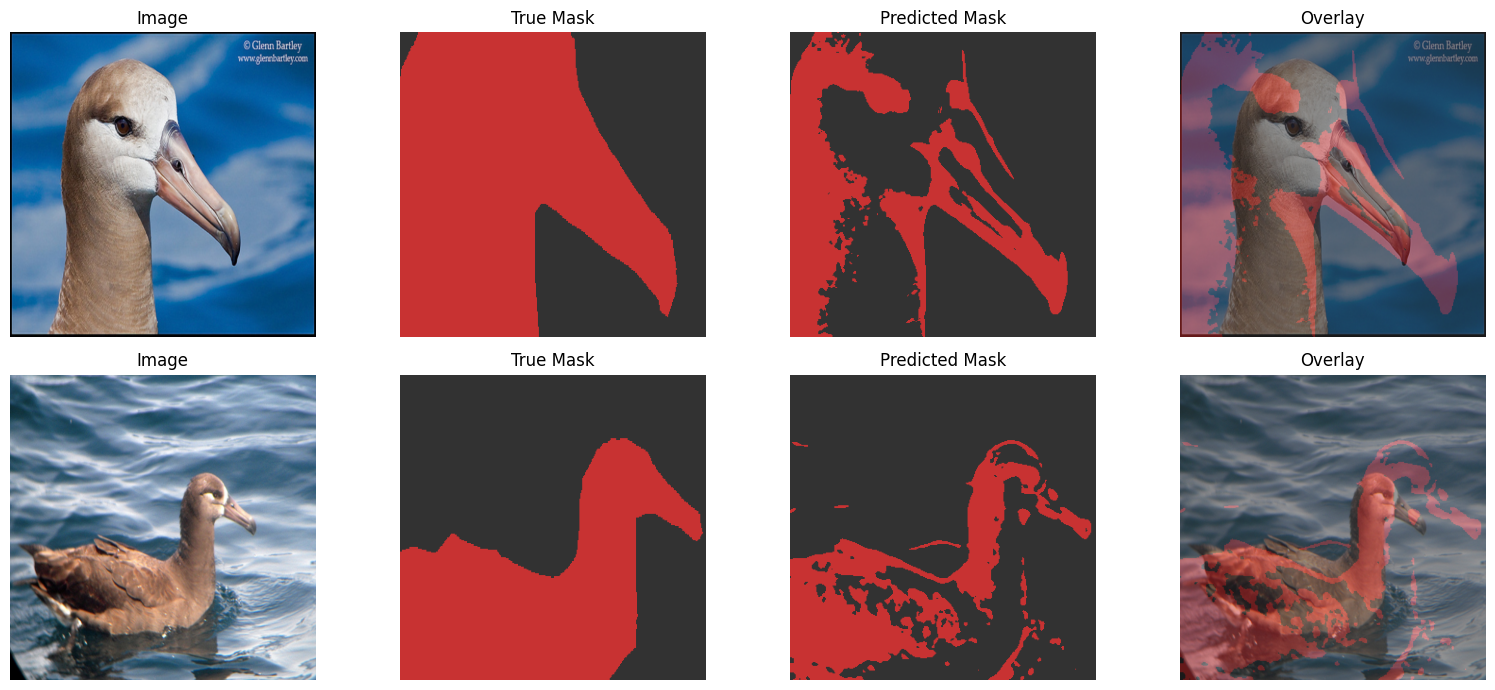

Epoch 1 [Eval]: 100%|██████████| 2897/2897 [02:52<00:00, 16.75it/s]


[Epoch:1] Validation mIoU: 53.67%
New best model saved! mIoU: 53.67% at epoch 1


Epoch 2 [Train]: 100%|██████████| 2997/2997 [02:05<00:00, 23.85it/s]


[Epoch:2] Train Loss: 0.5446, Time: 125.66s


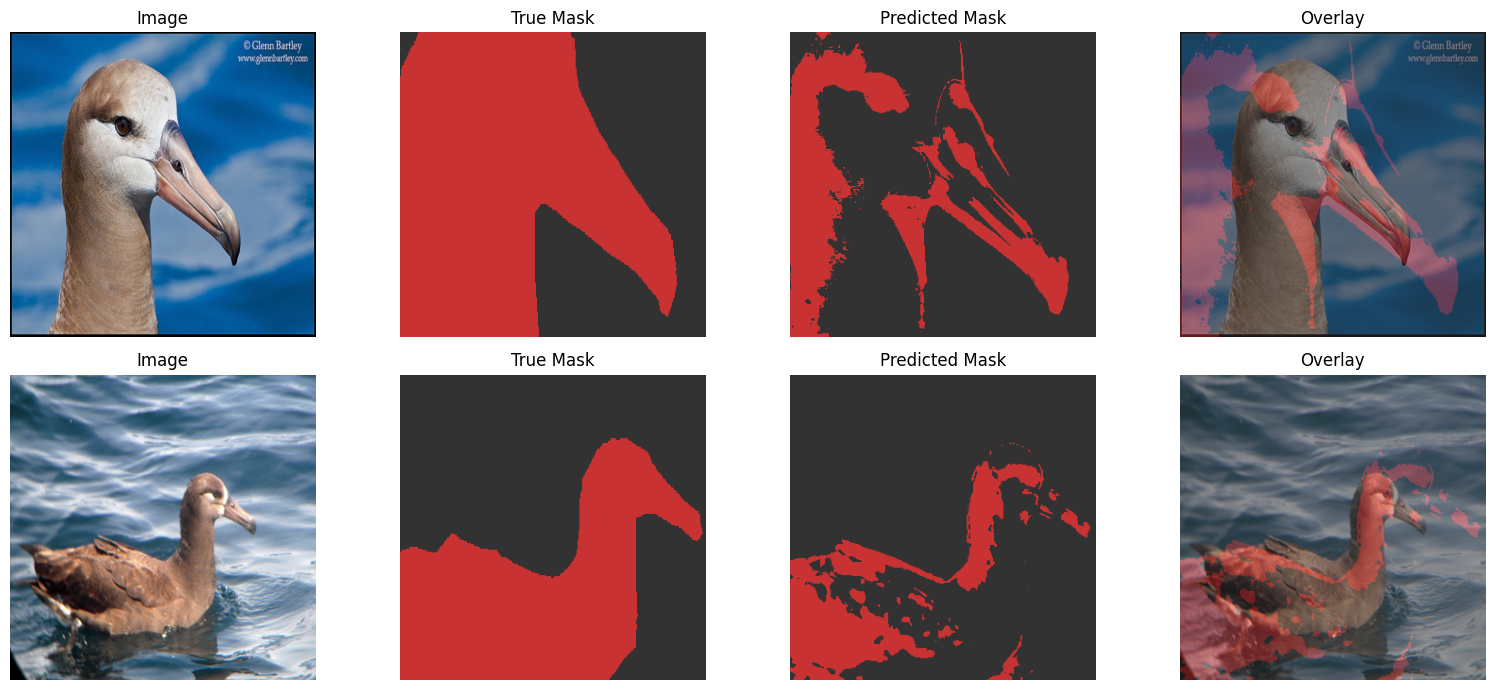

Epoch 2 [Eval]: 100%|██████████| 2897/2897 [02:47<00:00, 17.34it/s]


[Epoch:2] Validation mIoU: 54.01%
New best model saved! mIoU: 54.01% at epoch 2


Epoch 3 [Train]: 100%|██████████| 2997/2997 [02:05<00:00, 23.90it/s]


[Epoch:3] Train Loss: 0.5246, Time: 125.43s


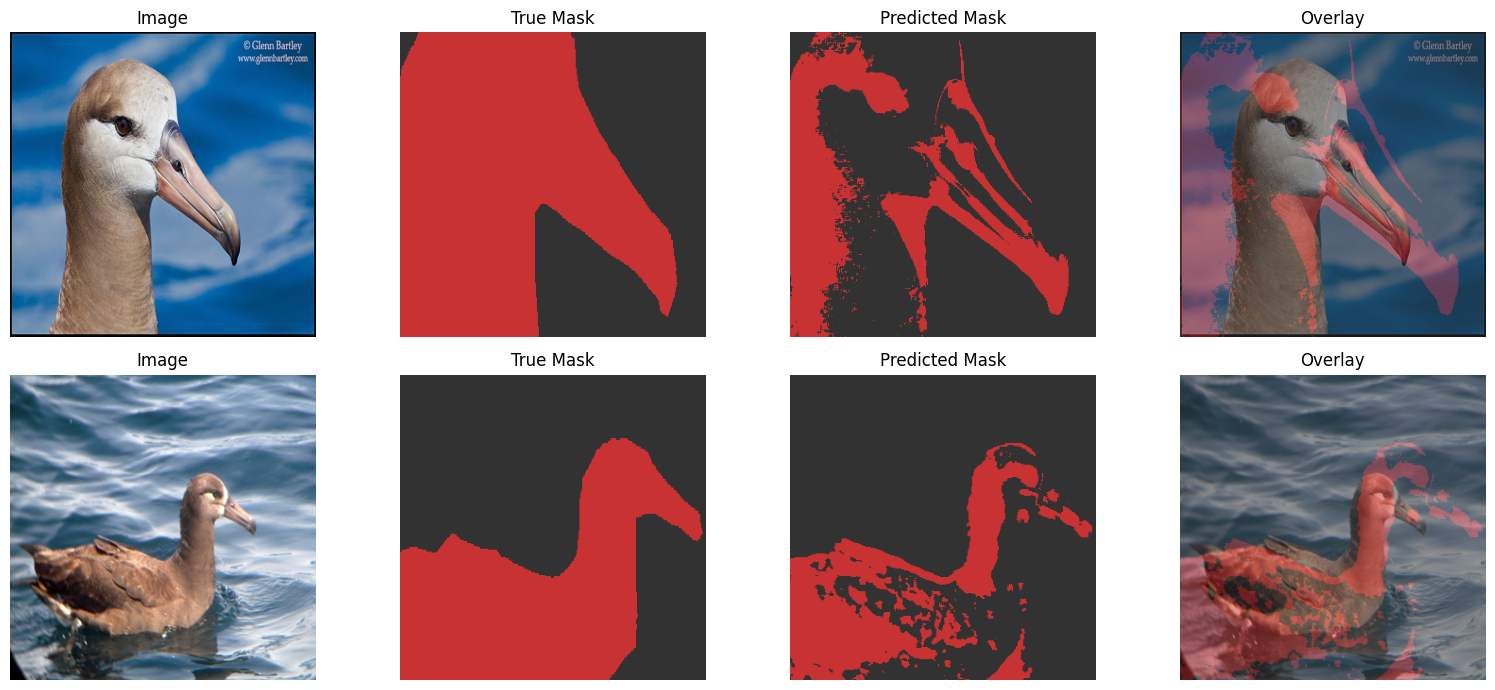

Epoch 3 [Eval]: 100%|██████████| 2897/2897 [02:24<00:00, 20.05it/s]


[Epoch:3] Validation mIoU: 54.74%
New best model saved! mIoU: 54.74% at epoch 3


Epoch 4 [Train]: 100%|██████████| 2997/2997 [02:05<00:00, 23.92it/s]


[Epoch:4] Train Loss: 0.5076, Time: 125.30s


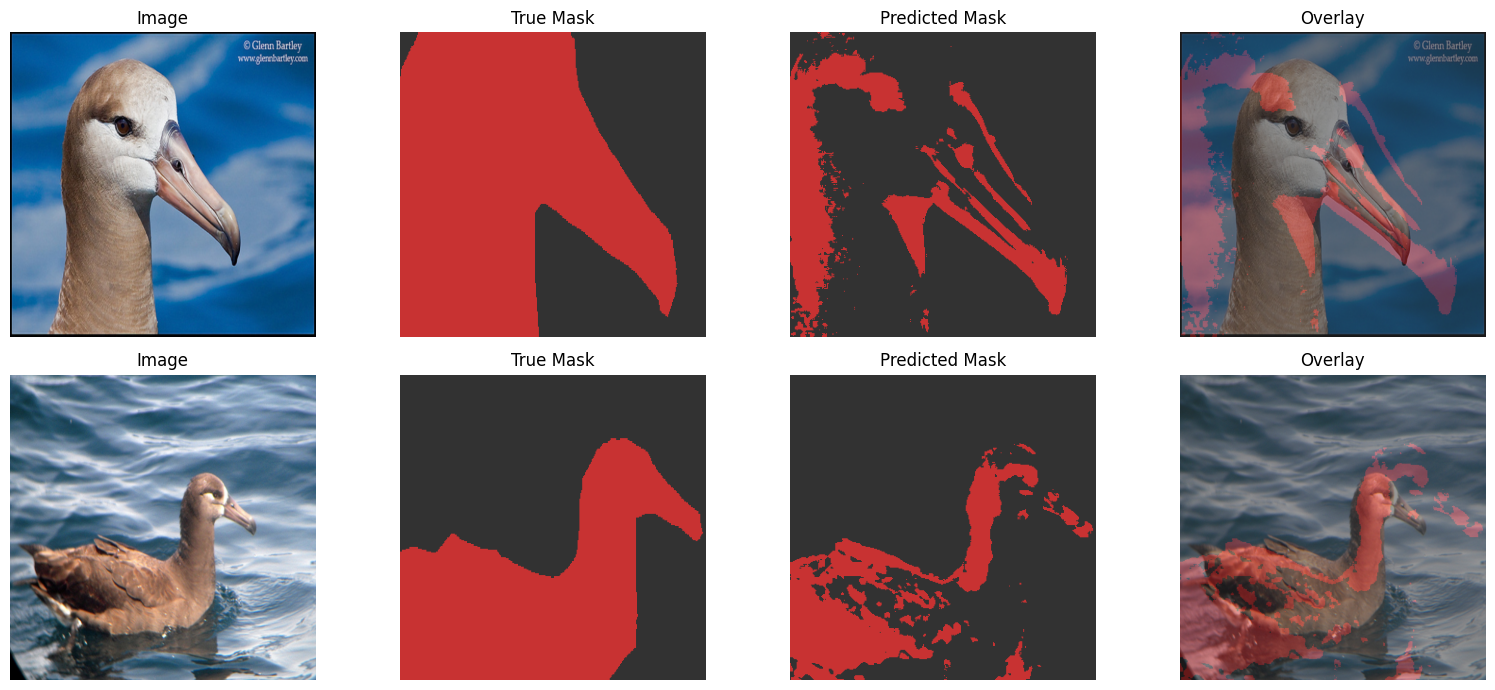

Epoch 4 [Eval]: 100%|██████████| 2897/2897 [02:24<00:00, 20.01it/s]


[Epoch:4] Validation mIoU: 53.80%


Epoch 5 [Train]: 100%|██████████| 2997/2997 [02:05<00:00, 23.87it/s]


[Epoch:5] Train Loss: 0.4962, Time: 125.54s


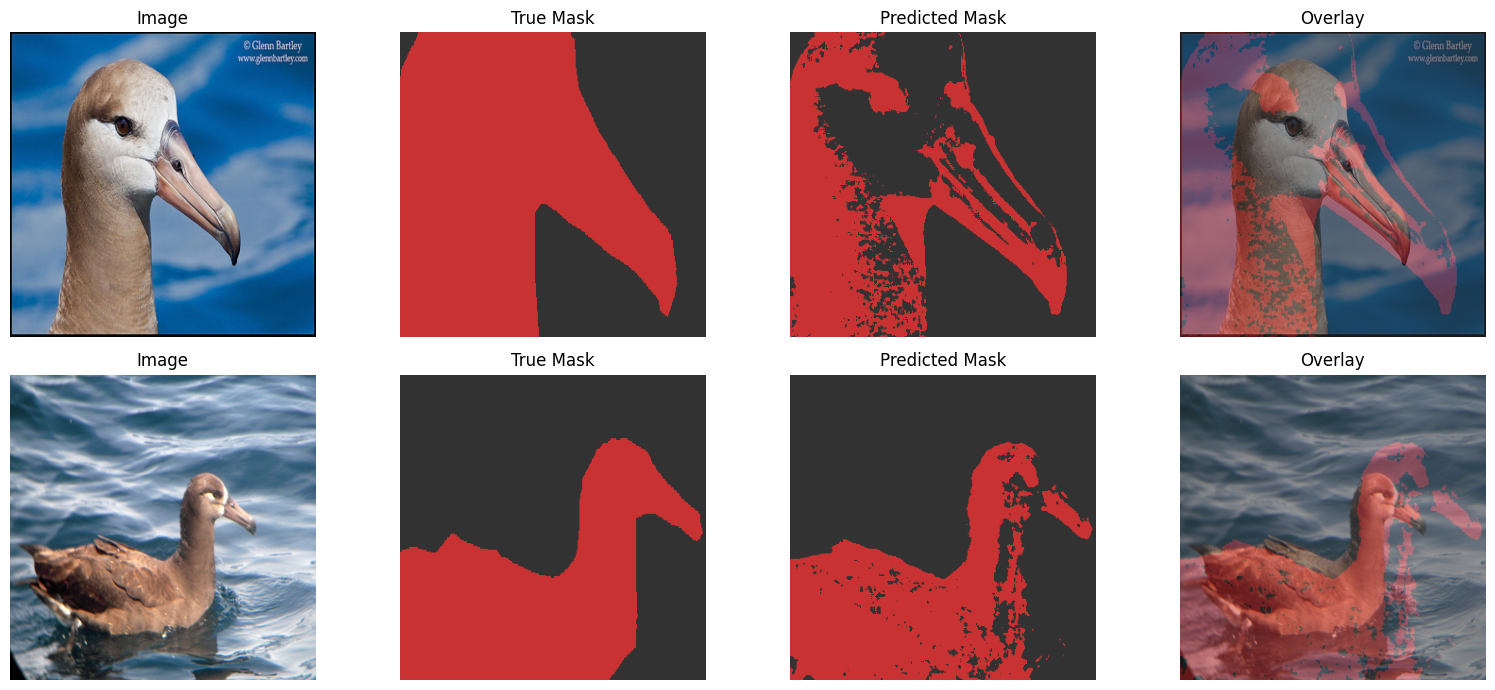

Epoch 5 [Eval]: 100%|██████████| 2897/2897 [02:25<00:00, 19.98it/s]

[Epoch:5] Validation mIoU: 53.57%


In [6]:
# ====================================================================================
# 1. 라이브러리 임포트
# - 필요한 모든 라이브러리를 이곳에 모아 관리합니다.
# ====================================================================================
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import time
from pathlib import Path
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as TF

# ====================================================================================
# 2. 하이퍼파라미터 및 전역 설정
# - 모델 학습에 필요한 주요 설정값들을 정의합니다.
# ====================================================================================
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DATA_ROOT = './data/CUB_200_2011'
BATCH_SIZE = 2
NUM_WORKERS = 4
EPOCHS = 5
LR = 0.005 # 학습률 (Learning Rate)
MOMENTUM = 0.9 # SGD 옵티마이저의 모멘텀 값
WEIGHT_DECAY = 0.0001 # 가중치 감쇠 (Overfitting 방지)
IMG_SIZE = 512 # 모델에 입력될 이미지의 크기
N_CLASSES = 2  # 최종 분류할 클래스 수: 배경(0), 새(1)
IGNORE_INDEX = 255 # 손실 계산 시 무시할 레이블 값 (주로 경계 등)

# 결과 및 모델 체크포인트 저장 경로 설정
OUT_DIR = 'runs'
BEST_PATH = './runs/best_model.pt'
os.makedirs(os.path.dirname(BEST_PATH), exist_ok=True)
print(f"Using device: {DEVICE}")


# ====================================================================================
# 3. 데이터 전처리 및 증강 함수
# - 이미지와 마스크에 적용할 변환 로직을 정의합니다.
# ====================================================================================
def make_transform(train):
    """학습(train) 여부에 따라 적절한 데이터 변환 및 증강 함수를 반환합니다."""
    def _tfm(img, mask):
        # 1) 리사이즈: 이미지와 마스크의 크기를 IMG_SIZE로 통일합니다.
        #    - 마스크는 픽셀값이 변하면 안되므로, 보간법(interpolation)으로 NEAREST(가장 가까운 픽셀)를 사용합니다.
        img = TF.resize(img, (IMG_SIZE, IMG_SIZE))
        mask = TF.resize(mask, (IMG_SIZE, IMG_SIZE), interpolation=TF.InterpolationMode.NEAREST)

        # 2) 데이터 증강(Augmentation): 학습(train=True) 시에만 50% 확률로 좌우반전을 적용합니다.
        #    - 동일한 변환을 이미지와 마스크에 함께 적용해야 위치가 어긋나지 않습니다.
        if train and torch.rand(1) < 0.5:
            img = TF.hflip(img)
            mask = TF.hflip(mask)

        # 3) 텐서 변환 및 정규화: 이미지를 모델 입력에 맞게 변환합니다.
        #    - to_tensor: PIL Image를 PyTorch 텐서로 변환하고 픽셀 값을 [0, 1] 범위로 스케일링합니다.
        img = TF.to_tensor(img)
        #    - normalize: ImageNet 데이터셋의 평균과 표준편차로 정규화하여 모델 학습을 안정화합니다.
        img = TF.normalize(img, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

        # 4) 마스크 처리: 마스크를 모델의 정답 레이블 형식에 맞게 변환합니다.
        mask_np = np.array(mask)
        #    - [에러 해결] CUB 데이터셋의 마스크는 채널 수가 (1, 2, 3)으로 다양합니다.
        #      모든 마스크를 일관된 단일 채널(2D) 형태로 통일하여 DataLoader 에러를 방지합니다.
        if mask_np.ndim == 3: # 3차원 배열(다채널)인 경우
            mask_np = (mask_np > 0).any(axis=2) # 채널 축을 기준으로 하나로 합칩니다.
        else: # 2차원 배열(단일 채널)인 경우
            mask_np = (mask_np > 0)
        
        #    - 0과 1로 구성된 정수형(uint8) 배열로 변환합니다.
        mask_np = mask_np.astype(np.uint8)
        #    - 최종적으로 손실 함수(CrossEntropyLoss)가 요구하는 torch.long 타입의 텐서로 변환합니다.
        mask = torch.as_tensor(mask_np, dtype=torch.long)
        return img, mask
    return _tfm

# ====================================================================================
# 4. 커스텀 데이터셋 및 로더 정의
# - CUB-200-2011 데이터셋을 불러오고 처리하는 부분을 담당합니다.
# ====================================================================================
class CUBBinarySg(Dataset):
    """CUB-200-2011 데이터셋을 위한 커스텀 데이터셋 클래스"""
    def __init__(self, root, img_ids, id2path, tf=None):
        self.root = Path(root)          # 데이터셋 루트 경로
        self.ids = img_ids              # 사용할 이미지 ID 리스트 (학습용 또는 검증용)
        self.id2path = id2path          # 이미지 ID와 파일 경로를 매핑하는 딕셔너리
        self.tf = tf                    # 적용할 transform 함수
        self.img_dir = self.root / 'images'
        self.seg_dir = self.root / 'segmentations'

    def __len__(self):
        # 데이터셋의 전체 샘플 수를 반환합니다.
        return len(self.ids)

    def __getitem__(self, idx):
        # 주어진 인덱스(idx)에 해당하는 샘플 1개를 반환합니다.
        img_idx = self.ids[idx]
        img_path_str = self.id2path[img_idx]

        # 1) 원본 이미지와 마스크를 PIL Image 객체로 불러옵니다.
        img_full_path = self.img_dir / img_path_str
        img = Image.open(img_full_path).convert('RGB') # RGB 채널로 통일

        img_path_obj = Path(img_path_str)
        sg_full_path = self.seg_dir / img_path_obj.with_suffix('.png')
        mask = Image.open(sg_full_path)

        # 2) transform 함수가 있다면, 이미지와 마스크에 적용합니다.
        if self.tf:
            img, mask = self.tf(img, mask)

        return img, mask

def read_id_to_path(root):
    """images.txt 파일을 읽어 {이미지 ID: 경로} 딕셔너리를 생성합니다."""
    id2path = {}
    with open(os.path.join(root, 'images.txt'), 'r') as f:
        for line in f:
            idx, p = line.strip().split(' ')
            id2path[int(idx)] = p
    return id2path

def read_tr_test_split(root):
    """train_test_split.txt 파일을 읽어 {이미지 ID: 학습(1)/테스트(0)} 딕셔너리를 생성합니다."""
    split = {}
    with open(os.path.join(root, 'train_test_split.txt'), 'r') as f:
        for line in f:
            idx, is_train = line.strip().split(' ')
            split[int(idx)] = int(is_train)
    return split

def get_loaders():
    """데이터셋과 데이터 로더를 생성하여 반환하는 메인 함수입니다."""
    root = DATA_ROOT
    id2path = read_id_to_path(root)
    split = read_tr_test_split(root)

    # 학습용 ID와 검증용 ID를 분리합니다.
    tr_ids = [i for i, t in split.items() if t == 1]
    val_ids = [i for i, t in split.items() if t == 0]

    # 각각의 데이터셋에 맞는 transform을 적용하여 데이터셋 인스턴스를 생성합니다.
    tr_ds = CUBBinarySg(root, tr_ids, id2path, tf=make_transform(train=True))
    val_ds = CUBBinarySg(root, val_ids, id2path, tf=make_transform(train=False))

    # 데이터 로더를 생성합니다.
    # - persistent_workers=True: 에폭 간 워커 프로세스를 유지하여 데이터 로딩 속도를 높입니다.
    tr_ds_loader = DataLoader(tr_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True, persistent_workers=True if NUM_WORKERS > 0 else False)
    val_ds_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True, persistent_workers=True if NUM_WORKERS > 0 else False)
    
    return tr_ds, val_ds, tr_ds_loader, val_ds_loader

# ====================================================================================
# 5. U-Net 모델 정의
# - 이미지 세그멘테이션을 위한 U-Net 아키텍처를 구성합니다.
# ====================================================================================
# U-Net의 기본 블록: (컨볼루션 -> 활성화함수) * 2
class DoubleConv(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(in_c, out_c, kernel_size=3, padding=0), # padding=0: "unpadded convolution"
            nn.ReLU(inplace=True),
            nn.Conv2d(out_c, out_c, kernel_size=3, padding=0),
            nn.ReLU(inplace=True))
    def forward(self, x):    
        return self.conv_block(x)

# U-Net 인코더(축소 경로)의 한 단계: 맥스 풀링 -> DoubleConv
class Down(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.down_block = nn.Sequential(nn.MaxPool2d(2), DoubleConv(in_c, out_c))
    def forward(self, x):
        return self.down_block(x)

# U-Net 디코더(확장 경로)의 한 단계: 업샘플링 -> Skip Connection 연결 -> DoubleConv
class Up(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        # ConvTranspose2d: 피처맵의 크기를 키우는 업샘플링(upsampling) 역할
        self.up = nn.ConvTranspose2d(in_c, in_c // 2, kernel_size=2, stride=2)
        self.block = DoubleConv(in_c, out_c) # 채널이 합쳐진 후의 컨볼루션
    def forward(self, x, skip):
        x = self.up(x) # 1. 업샘플링
        # 2. Skip Connection으로 받은 피처맵(skip)을 현재 크기(x)에 맞게 중앙 크롭(center crop)
        th, tw = x.shape[-2:]
        Hs, Ws = skip.shape[-2:]
        dh, dw = (Hs - th) // 2, (Ws - tw) // 2
        skip_c = skip[..., dh:dh + th, dw:dw + tw]
        # 3. 채널(dim=1)을 기준으로 두 피처맵을 연결
        x = torch.cat([skip_c, x], dim=1)
        # 4. DoubleConv 블록 통과
        out = self.block(x)
        return out

# U-Net 전체 아키텍처
class UNet(nn.Module):
    def __init__(self, in_c=3, n_classes=2, base_channels=64):
        super().__init__()
        # 인코더 (Contracting Path)
        self.inc = DoubleConv(in_c, base_channels)
        self.down1 = Down(base_channels, base_channels * 2)
        self.down2 = Down(base_channels * 2, base_channels * 4)
        self.down3 = Down(base_channels * 4, base_channels * 8)
        self.down4 = Down(base_channels * 8, base_channels * 16)
        # 디코더 (Expansive Path)
        self.up1 = Up(base_channels * 16, base_channels * 8)
        self.up2 = Up(base_channels * 8, base_channels * 4)
        self.up3 = Up(base_channels * 4, base_channels * 2)
        self.up4 = Up(base_channels * 2, base_channels)
        # 최종 출력 레이어: 1x1 컨볼루션으로 클래스 수에 맞는 출력 생성
        self.outc = nn.Conv2d(base_channels, n_classes, kernel_size=1)

    def forward(self, x):
        # 인코더를 통과하며 각 단계의 출력을 저장 (skip connection용)
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        # 디코더를 통과하며 skip connection과 연결
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        # 최종 출력
        out = self.outc(x)
        return out

# ====================================================================================
# 6. 시각화 및 평가 헬퍼 함수
# - 학습 결과를 시각화하고 성능(mIoU)을 측정하는 함수들을 정의합니다.
# ====================================================================================
BG_COLOR = np.array([50, 50, 50], dtype=np.uint8)
BIRD_COLOR = np.array([200, 50, 50], dtype=np.uint8)
IGNORE_COLOR = np.array([100, 100, 100], dtype=np.uint8)

def _denorm(img):
    """정규화된 이미지를 다시 [0, 1] 범위의 시각화 가능한 이미지로 되돌립니다."""
    mean = torch.tensor([0.485, 0.456, 0.406], device=img.device)[:, None, None]
    std = torch.tensor([0.229, 0.224, 0.225], device=img.device)[:, None, None]
    img = (img * std + mean).clamp(0, 1)
    return img.detach().cpu().numpy().transpose(1, 2, 0)

def _colorize_binary(mask_np, ignore_idx=255):
    """0과 1로 이루어진 마스크를 지정된 색상으로 변환합니다."""
    out = np.zeros((*mask_np.shape, 3), dtype=np.uint8)
    out[mask_np == 0] = BG_COLOR
    out[mask_np == 1] = BIRD_COLOR
    out[mask_np == ignore_idx] = IGNORE_COLOR
    return out

def overlay_mask(img_np, mask_rgb, alpha=0.5):
    """원본 이미지 위에 마스크를 반투명하게 겹쳐서 보여줍니다."""
    base = (img_np * 255).astype(np.uint8)
    over = (alpha * mask_rgb + (1 - alpha) * base).astype(np.uint8)
    return over

def show_samples(model, loader, batches=1, alpha=0.5, ignore_idx=255, max_rows=None):
    """모델의 예측 결과를 (이미지, 정답 마스크, 예측 마스크, 오버레이) 형태로 시각화합니다."""
    model.eval()
    it = iter(loader)
    for _ in range(batches):
        try:
            batch = next(it)
        except StopIteration:
            break
        
        x, y = batch[0], batch[1]
        imgs, gts = x.to(DEVICE), y.to(DEVICE)

        with torch.no_grad():
            logits = model(imgs)
        
        gts_c = center_crop(gts, logits.shape[-2:])
        preds = torch.argmax(logits, dim=1)

        B = min(max_rows, imgs.size(0)) if max_rows is not None else imgs.size(0)
        r, c = B, 4
        plt.figure(figsize=(c * 4, r * 3.5))
        for i in range(B):
            img_np = _denorm(imgs[i])
            gt_np = gts_c[i].detach().cpu().numpy()
            pr_np = preds[i].detach().cpu().numpy()
            gt_rgb = _colorize_binary(gt_np, ignore_idx)
            pr_rgb = _colorize_binary(pr_np, ignore_idx)
            
            # [에러 해결] 예측 마스크(pr_rgb)는 모델 출력 크기(e.g., 324x324)이고
            # 원본 이미지(img_np)는 입력 크기(512x512)이므로, 시각화를 위해 크기를 맞춰줍니다.
            h, w, _ = img_np.shape
            pr_rgb_resized = Image.fromarray(pr_rgb).resize((w, h), Image.NEAREST)
            pr_rgb_resized = np.array(pr_rgb_resized)
            
            over = overlay_mask(img_np, pr_rgb_resized, alpha)
            
            plt.subplot(r, c, i*4 + 1); plt.imshow(img_np); plt.title('Image'); plt.axis('off')
            plt.subplot(r, c, i*4 + 2); plt.imshow(gt_rgb); plt.title('True Mask'); plt.axis('off')
            plt.subplot(r, c, i*4 + 3); plt.imshow(pr_rgb); plt.title('Predicted Mask'); plt.axis('off')
            plt.subplot(r, c, i*4 + 4); plt.imshow(over); plt.title('Overlay'); plt.axis('off')
            
        plt.tight_layout()
        plt.show()

def center_crop(t, size_hw):
    """텐서의 중앙 부분을 지정된 크기로 잘라냅니다."""
    H, W = t.shape[-2:]
    th, tw = size_hw
    dh, dw = (H - th) // 2, (W - tw) // 2
    return t[..., dh:dh + th, dw:dw + tw]

def fast_hist(pred, label, n_class):
    """혼동 행렬(Confusion Matrix)을 효율적으로 계산합니다."""
    k = (0 <= label) & (label < n_class)
    return np.bincount(n_class * label[k].astype(int) + pred[k].astype(int), minlength=n_class**2).reshape(n_class, n_class)

def miou_from_hist(hist):
    """혼동 행렬로부터 mIoU(mean Intersection over Union)를 계산합니다."""
    iu = np.diag(hist) / (hist.sum(axis=1) + hist.sum(axis=0) - np.diag(hist) + 1e-10)
    return float(np.nanmean(iu)), iu

# ====================================================================================
# 7. 학습 및 평가 루프
# - 실제 모델 학습과 평가가 이루어지는 핵심 로직입니다.
# ====================================================================================
def train(model, criterion, opt, scaler, loader, device, epoch):
    """한 에폭(epoch) 동안 모델을 학습시키는 함수"""
    model.train()
    running_loss = 0.0
    t0 = time.time()
    for x, y in tqdm(loader, desc=f"Epoch {epoch} [Train]"):
        imgs, masks = x.to(device), y.to(device)
        opt.zero_grad(set_to_none=True)
        
        # Mixed Precision Training: 연산 속도 향상 및 메모리 절약
        with torch.amp.autocast(device_type=device.type, enabled=torch.cuda.is_available()):
            logits = model(imgs)
            masks_c = center_crop(masks, logits.shape[-2:])
            loss = criterion(logits, masks_c)
        
        # 역전파
        scaler.scale(loss).backward()
        scaler.step(opt)
        scaler.update()
        running_loss += loss.item() * imgs.size(0)

    avg_loss = running_loss / len(loader.dataset)
    print(f'[Epoch:{epoch}] Train Loss: {avg_loss:.4f}, Time: {time.time() - t0:.2f}s')
    return avg_loss

@torch.no_grad() # 평가 시에는 그래디언트 계산이 필요 없으므로 비활성화
def evaluate(model, loader, device, epoch):
    """데이터셋에 대한 모델의 성능(mIoU)을 평가하는 함수"""
    model.eval()
    hist = np.zeros((N_CLASSES, N_CLASSES), dtype=np.float64)
    for batch in tqdm(loader, desc=f"Epoch {epoch} [Eval]"):
        x, y = batch[0], batch[1]
        imgs, masks = x.to(device), y.to(device)
        logits = model(imgs)
        masks_c = center_crop(masks, logits.shape[-2:])
        preds = torch.argmax(logits, dim=1)
        hist += fast_hist(preds.cpu().numpy().flatten(), masks_c.cpu().numpy().flatten(), N_CLASSES)
    
    miou, _ = miou_from_hist(hist)
    print(f'[Epoch:{epoch}] Validation mIoU: {miou * 100:.2f}%')
    return miou

# ====================================================================================
# 8. 메인 실행 블록
# - 전체 코드를 실행하고 학습-평가 사이클을 관리합니다.
# ====================================================================================
if __name__ == '__main__':
    # 데이터 로더 준비
    tr_ds, val_ds, tr_ds_loader, val_ds_loader = get_loaders()-
    
    # 모델, 손실 함수, 옵티마이저, 스케일러 초기화
    model = UNet(in_c=3, n_classes=N_CLASSES).to(DEVICE)
    criterion = nn.CrossEntropyLoss(ignore_index=IGNORE_INDEX)
    opt = torch.optim.SGD(model.parameters(), lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
    
    # [에러 해결] GradScaler는 device_type 인수를 받지 않으므로 제거합니다.
    scaler = torch.amp.GradScaler(enabled=torch.cuda.is_available())

    best_miou = -1.0 # 최고 성능(mIoU)을 기록하기 위한 변수
    
    # 지정된 에폭 수만큼 학습 및 평가 반복
    for ep in range(1, EPOCHS + 1):
        # 1. 학습
        train(model, criterion, opt, scaler, tr_ds_loader, DEVICE, ep)
        
        # 2. 검증 데이터셋 샘플로 예측 결과 시각화
        show_samples(model, val_ds_loader, batches=1, max_rows=4)
        
        # 3. 평가
        miou = evaluate(model, val_ds_loader, DEVICE, ep)
        
        # 4. 최고 성능 모델 저장
        if miou > best_miou:
            best_miou = miou
            # 모델의 state_dict와 학습 관련 정보를 함께 저장
            torch.save(
                {
                    'epoch': ep, 'model': model.state_dict(), 'miou': best_miou,
                    'config': {'IMG_SIZE': IMG_SIZE, 'N_CLASSES': N_CLASSES, 'LR': LR,
                               'MOMENTUM': MOMENTUM, 'WEIGHT_DECAY': WEIGHT_DECAY}
                }, BEST_PATH)
            print(f'New best model saved! mIoU: {best_miou * 100:.2f}% at epoch {ep}')

In [6]:
!pip install kagglehub

Looking in indexes: https://mirror.kakao.com/pypi/simple


In [7]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("tschandl/isic2018-challenge-task1-data-segmentation")

print("Path to dataset files:", path)

100%|██████████| 12.9G/12.9G [07:03<00:00, 32.7MB/s]  

Extracting files...


Path to dataset files: /workspace/.cache/kagglehub/datasets/tschandl/isic2018-challenge-task1-data-segmentation/versions/1


In [8]:
import kagglehub
import shutil
import os

path = '/workspace/.cache/kagglehub/datasets/tschandl/isic2018-challenge-task1-data-segmentation/versions/1'

# 2. 내가 원하는 경로
target_dir = "./data/isic2018"   # 원하는 폴더 지정
os.makedirs(target_dir, exist_ok=True)

# 3. 데이터 이동
shutil.move(path, target_dir)

print("최종 저장 경로:", target_dir)

최종 저장 경로: ./data/isic2018


In [11]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("devdgohil/the-oxfordiiit-pet-dataset")

print("Path to dataset files:", path)

100%|██████████| 780M/780M [00:26<00:00, 31.5MB/s] 

Extracting files...


Path to dataset files: /workspace/.cache/kagglehub/datasets/devdgohil/the-oxfordiiit-pet-dataset/versions/2
